In [1]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv('/content/drive/MyDrive/cleandata.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  44898 non-null  int64 
 1   text        44897 non-null  object
 2   label       44898 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


In [5]:
train.label.value_counts()

1    23481
0    21417
Name: label, dtype: int64

In [6]:
train.dropna(inplace = True)
news = train

In [7]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44897 entries, 0 to 44897
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  44897 non-null  int64 
 1   text        44897 non-null  object
 2   label       44897 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.4+ MB


In [14]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 14.6 MB/s 
     |████████████████████████████████| 7.6 MB 66.2 MB/s 
     |████████████████████████████████| 182 kB 81.7 MB/s 


In [9]:
from sklearn.model_selection import train_test_split
train, test, labels, y_test = train_test_split(news, news['label'], test_size=0.2, stratify=news['label'],random_state=123, shuffle=True)
sentences = train.text.values
labels=labels.values
     

In [10]:
# import tensorflow as tf
# # Get the GPU device name.
# device_name = tf.test.gpu_device_name()
# # The device name should look like the following:
# if device_name == '/device:GPU:0':
#     print('Found GPU at: {}'.format(device_name))
# else:
#     raise SystemError('GPU device not found')

In [11]:
import torch
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [15]:
from transformers import BertTokenizer
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [16]:
input_ids = []
for sent in sentences:
 
    encoded_sent = tokenizer.encode(
                        sent,                      
                        add_special_tokens = True, 
                   )
    
    
    input_ids.append(encoded_sent)

print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Token indices sequence length is longer than the specified maximum sequence length for this model (555 > 512). Running this sequence through the model will result in indexing errors


Original:   next round aid help rebuild puerto rico state destruct hurrican wildfir unlik consid congress take catch spend bill face dec deadlin passag senat republican said wednesday john cornyn said crush matter would take time probabl get disast aid consider massiv bill fund feder agenc next sept trump administr said submit congress third round disast aid mid novemb could total ten billion dollar congress alreadi provid billion current republican control congress mainli focus pas major tax reform bill year end disast aid would help recoveri effort texa florida puerto rico virgin island follow hurrican harvey irma maria august septemb six week maria tore puerto rico island struggl pick piec two third resid remain without power territori declar bankruptci earlier year storm plung economi deeper uncertainti govern wide spend bill could also becom magnet measur democrat minor congress want attach could includ bipartisan plan temporarili bolster afford care act commonli known obamacar de

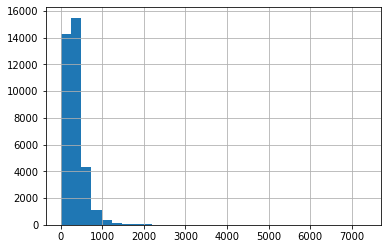

In [17]:
seq_len = [len(sen) for sen in input_ids]
pd.Series(seq_len).hist(bins = 30)

In [18]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  7329


In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
MAX_LEN = 96
print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
print('\Done.')


Padding/truncating all sentences to 96 values...

Padding token: "[PAD]", ID: 0
\Done.


In [20]:
attention_masks = []
for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)
     

In [21]:
from sklearn.model_selection import train_test_split
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=123, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=123, test_size=0.1)

In [22]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [23]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)
     

In [24]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-uncased", 
    num_labels = 2, 
    output_attentions = False, 
    output_hidden_states = False, 
)
model.cuda()

Downloading:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [63]:
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (105879, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

In [26]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )
from transformers import get_linear_schedule_with_warmup

epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [27]:
import numpy as np
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
     

In [66]:
import time
import datetime
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [67]:
import random
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
# Set the seed value all over the place to make this reproducible.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []
start=time.time()
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_loss = 0
    model.train()
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        # Unpack this training batch from our dataloader. 
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Always clear any previously calculated gradients before performing a backward pass.

        model.zero_grad()        
        # Perform a forward pass .This will return the loss .
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the loss value out of the tuple.
        loss = outputs[0]
        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end. `loss` is a Tensor containing a single value
        total_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0. This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and  speeding up validation
        with torch.no_grad():        
            # Forward pass, calculate logit predictions. This will return the logits rather than the loss because we have not provided labels.
            # token_type_ids is the same as the "segment ids"
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. 
        logits = outputs[0]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        # Track the number of batches
        nb_eval_steps += 1
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
print("Training complete!")
end=time.time()


======== Epoch 1 / 5 ========
Training...
  Batch    40  of  1,011.    Elapsed: 0:00:23.
  Batch    80  of  1,011.    Elapsed: 0:00:44.
  Batch   120  of  1,011.    Elapsed: 0:01:06.
  Batch   160  of  1,011.    Elapsed: 0:01:27.
  Batch   200  of  1,011.    Elapsed: 0:01:50.
  Batch   240  of  1,011.    Elapsed: 0:02:12.
  Batch   280  of  1,011.    Elapsed: 0:02:35.
  Batch   320  of  1,011.    Elapsed: 0:02:57.
  Batch   360  of  1,011.    Elapsed: 0:03:20.
  Batch   400  of  1,011.    Elapsed: 0:03:42.
  Batch   440  of  1,011.    Elapsed: 0:04:04.
  Batch   480  of  1,011.    Elapsed: 0:04:27.
  Batch   520  of  1,011.    Elapsed: 0:04:49.
  Batch   560  of  1,011.    Elapsed: 0:05:11.
  Batch   600  of  1,011.    Elapsed: 0:05:34.
  Batch   640  of  1,011.    Elapsed: 0:05:56.
  Batch   680  of  1,011.    Elapsed: 0:06:18.
  Batch   720  of  1,011.    Elapsed: 0:06:41.
  Batch   760  of  1,011.    Elapsed: 0:07:03.
  Batch   800  of  1,011.    Elapsed: 0:07:26.
  Batch   840  of

In [68]:
import plotly.express as px
f = pd.DataFrame(loss_values)
f.columns=['Loss']
fig = px.line(f, x=f.index, y=f.Loss)
fig.update_layout(title='Training loss of the Model',
                   xaxis_title='Epoch',
                   yaxis_title='Loss')
fig.show()

In [70]:
sentences = test.text.values
labels = y_test.values
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
for sent in sentences:
  
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 256
                   )
    
    input_ids.append(encoded_sent)
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 
# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
# Set the batch size.  
batch_size = 32  
# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)
     

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [91]:
torch.save(model.state_dict(),'bestmodel')

In [71]:
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))
# Put model in evaluation mode
model.eval()

predictions , true_labels = [], []
# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  

  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
  logits = outputs[0]
  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
print('DONE.')

Predicting labels for 8,980 test sentences...
DONE.


In [72]:

count=0
guesses=[]
actual=[]
# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" and one column for "1"). Pick the label with the highest value and turn this in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  

  #calculate accuracy
  for j in range(len(pred_labels_i)):
    if(pred_labels_i[j]==true_labels[i][j]):
      count+=1
    guesses.append(pred_labels_i[j])
    actual.append(true_labels[i][j])
    

accuracy = count/len(y_test)

In [73]:
print(accuracy)

0.983184855233853


In [82]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score,classification_report,confusion_matrix
print(accuracy_score(actual, guesses))
print(recall_score(actual, guesses))
print(precision_score(actual, guesses))
print(f1_score(actual, guesses))

0.983184855233853
0.977427597955707
0.9902912621359223
0.9838173829171578


In [78]:
print(classification_report(actual,guesses))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4284
           1       0.99      0.98      0.98      4696

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



In [87]:
x = confusion_matrix(actual,guesses)

In [86]:
import seaborn as sns

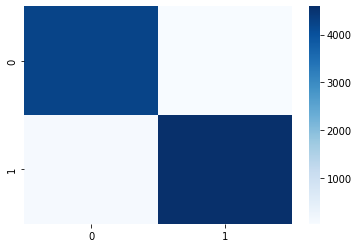

In [90]:
sns.heatmap(x,cmap = "Blues")